
# Diffusion From Scratch — **Unconditional DDPM (vanilla)**



## Concept cheat-sheet
- Forward: $(x_t = \sqrt{\bar\alpha_t}\,x_0 + \sqrt{1-\bar\alpha_t}\,\epsilon)$
- Train: predict $(\epsilon)$ with MSE
- Reverse: ancestral DDPM update with posterior variance


## 0) Setup & Utilities

In [1]:

# %pip install torch torchvision matplotlib --quiet
import os, sys, math, random
from dataclasses import dataclass
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
try:
    from torchvision import datasets, transforms, utils as vutils
    HAS_TORCHVISION=True
except Exception as e:
    HAS_TORCHVISION=False
    print("torchvision not available; using synthetic.", e)
import matplotlib.pyplot as plt

def pick_device():
    if torch.cuda.is_available(): return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available(): return torch.device("mps")
    return torch.device("cpu")
DEVICE = pick_device(); print("Using:", DEVICE)

def set_seed(s=42):
    random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s); torch.use_deterministic_algorithms(False)
set_seed()

def make_grid(imgs, nrow=8):
    if HAS_TORCHVISION:
        return vutils.make_grid(imgs, nrow=nrow, normalize=True, value_range=(-1,1))
    b,c,h,w = imgs.shape; rows=(b+nrow-1)//nrow
    canvas=torch.zeros(c, rows*h, nrow*w, device=imgs.device); k=0
    for r in range(rows):
        for c2 in range(nrow):
            if k>=b: break
            canvas[:, r*h:(r+1)*h, c2*w:(c2+1)*w] = imgs[k]; k+=1
    return canvas

def show_images(imgs, nrow=8, title=None):
    grid = make_grid(imgs, nrow=nrow)
    plt.figure(figsize=(7,7)); plt.imshow(grid.permute(1,2,0).cpu().numpy(), interpolation="nearest"); plt.axis("off")
    if title: plt.title(title); plt.show()


Using: mps


## 1) Data — MNIST→32×32, grayscale

Batch: torch.Size([128, 1, 32, 32]) -1.0 1.0


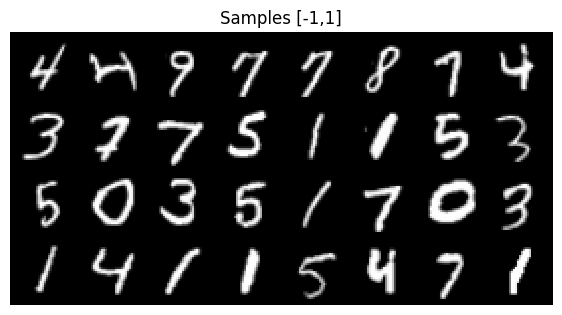

In [20]:

IMG_SIZE=32; BATCH_SIZE=128; LIMIT=10000;
class TinySynthetic(Dataset):
    def __init__(self, n=6000, img_size=32): self.n=n; self.img_size=img_size
    def __len__(self): return self.n
    def __getitem__(self, idx):
        x=torch.randn(1,self.img_size,self.img_size)
        x=torch.tanh(x) # (-1,1)
        return x,0

if HAS_TORCHVISION:
    transform=torchvision_transforms=transforms.Compose(
        [
            transforms.Resize(IMG_SIZE), 
            transforms.ToTensor(), 
            transforms.Lambda(lambda t:t*2-1)
        ])
    try:
        train_full=datasets.MNIST("./data", train=True, download=True, transform=transform)
        test_set=datasets.MNIST("./data", train=False, download=True, transform=transform)
        idx=torch.randperm(len(train_full))[:LIMIT]; train_set=Subset(train_full, idx.tolist())
    except Exception as e:
        print("MNIST failed; using FakeData.", e)
        try:
            train_set=datasets.FakeData(size=LIMIT, image_size=(1,IMG_SIZE,IMG_SIZE), transform=transform)
            test_set=datasets.FakeData(size=2000, image_size=(1,IMG_SIZE,IMG_SIZE), transform=transform)
        except Exception as e2:
            print("FakeData unavailable; synthetic.", e2); train_set=TinySynthetic(LIMIT, IMG_SIZE); test_set=TinySynthetic(2000, IMG_SIZE)
else:
    train_set=TinySynthetic(LIMIT, IMG_SIZE); test_set=TinySynthetic(2000, IMG_SIZE)

train_loader=DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader=DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

xb,_=next(iter(train_loader)); print("Batch:", xb.shape, xb.min().item(), xb.max().item())
show_images(xb[:32], nrow=8, title="Samples [-1,1]")
iter(train_loader)

## 2) Scheduler (linear/cosine)

In [21]:

@dataclass
class DiffusionConfig:
    timesteps:int=1000; beta_start:float=1e-4; beta_end:float=2e-2; schedule:str="linear"

class DiffusionScheduler:
    def __init__(self, cfg:DiffusionConfig, device):
        self.cfg=cfg
        self.T=cfg.timesteps
        self.device=device
        self._setup()
    def _linear(self): return torch.linspace(self.cfg.beta_start, self.cfg.beta_end, self.T, device=self.device)
    def _cosine(self, s:float=0.008):
        t=torch.linspace(0,1,self.T+1, device=self.device)
        a=(torch.cos(((t+s)/(1+s))*math.pi/2)**2)
        a=a/a[0]; betas=1-(a[1:]/a[:-1])
        return betas.clamp(1e-8,0.999)
    def _setup(self):
        betas=self._cosine() if self.cfg.schedule=="cosine" else self._linear()
        alphas=1-betas; abar=torch.cumprod(alphas, dim=0)
        self.betas=betas
        self.alphas=alphas
        self.abar=abar
        self.sqrt_abar=torch.sqrt(abar)
        self.sqrt_1m_abar=torch.sqrt(1-abar)
        self.sqrt_inv_a=torch.sqrt(1/alphas)
        abar_prev=torch.cat([torch.tensor([1.0], device=self.device), abar[:-1]], dim=0)
        self.post_var= betas*(1-abar_prev)/(1-abar)
        self.post_log_var=torch.log(self.post_var.clamp(min=1e-20))
    def add_noise(self, x0, t, eps): 
        return self.sqrt_abar[t].view(-1,1,1,1)*x0 + self.sqrt_1m_abar[t].view(-1,1,1,1)*eps
    def step(self, xt, t, eps_pred):
        beta_t=self.betas[t].view(-1,1,1,1); a_t=self.alphas[t].view(-1,1,1,1); abar_t=self.abar[t].view(-1,1,1,1)
        sqrt_inv_a_t=self.sqrt_inv_a[t].view(-1,1,1,1)
        mean = sqrt_inv_a_t*(xt - beta_t/torch.sqrt(1-abar_t+1e-8)*eps_pred)
        if (t>0).all():
            var=self.post_var[t].view(-1,1,1,1); z=torch.randn_like(xt); return mean + torch.sqrt(var)*z
        return mean


## 3) Tiny UNet

In [24]:

def sinusoidal_time_embedding(t, dim):
    half=dim//2
    freqs=torch.exp(torch.linspace(math.log(1e-4), math.log(1.0), half, device=t.device))
    args=t.float().unsqueeze(1)*freqs.unsqueeze(0)
    emb=torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    if dim%2==1: emb=torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
    return emb

class ResBlock(nn.Module):
    def __init__(self, in_ch,out_ch,time_dim):
        super().__init__()
        self.n1=nn.GroupNorm(8,in_ch); self.act=nn.SiLU(); self.c1=nn.Conv2d(in_ch,out_ch,3,padding=1)
        self.tmlp=nn.Sequential(nn.SiLU(), nn.Linear(time_dim,out_ch))
        self.n2=nn.GroupNorm(8,out_ch); self.c2=nn.Conv2d(out_ch,out_ch,3,padding=1)
        self.skip=nn.Conv2d(in_ch,out_ch,1) if in_ch!=out_ch else nn.Identity()
    def forward(self,x,t_emb):
        h=self.c1(self.act(self.n1(x))); h=h+self.tmlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h=self.c2(self.act(self.n2(h))); return h+self.skip(x)

class Down(nn.Module):
    def __init__(self,in_ch,out_ch,time_dim):
        super().__init__()
        self.b1=ResBlock(in_ch,out_ch,time_dim)
        self.b2=ResBlock(out_ch,out_ch,time_dim)
        self.pool=nn.Conv2d(out_ch,out_ch,3,stride=2,padding=1)
    def forward(self,x,t_emb):
        x=self.b1(x,t_emb)
        x=self.b2(x,t_emb)
        skip=x
        x=self.pool(x)
        return x,skip

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, skip_ch, time_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 4, stride=2, padding=1)
        # after concat: channels = out_ch (upsampled) + skip_ch
        self.b1 = ResBlock(out_ch + skip_ch, out_ch, time_dim)
        self.b2 = ResBlock(out_ch, out_ch, time_dim)

    def forward(self, x, skip, t_emb):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.b1(x, t_emb)
        x = self.b2(x, t_emb)
        return x

class TinyUNet(nn.Module):
    def __init__(self, in_channels=1, base=32, time_dim=128):
        super().__init__()
        self.time_dim = time_dim
        self.temb = nn.Sequential(nn.Linear(time_dim, time_dim), nn.SiLU(), nn.Linear(time_dim, time_dim))

        self.in_conv = nn.Conv2d(in_channels, base, 3, padding=1)

        # Downs: (C) base -> 64 -> 128
        self.d1 = Down(base,    base*2, time_dim)  # skip: 64
        self.d2 = Down(base*2,  base*4, time_dim)  # skip: 128

        # Mid
        self.m1 = ResBlock(base*4, base*4, time_dim)
        self.m2 = ResBlock(base*4, base*4, time_dim)

        # Ups: specify skip_ch explicitly
        self.u1 = Up(in_ch=base*4, out_ch=base*2, skip_ch=base*4, time_dim=time_dim)  # 64 + 128 -> 64
        self.u2 = Up(in_ch=base*2, out_ch=base,   skip_ch=base*2, time_dim=time_dim)  # 32 + 64  -> 32

        self.out_n = nn.GroupNorm(8, base)
        self.out_c = nn.Conv2d(base, in_channels, 3, padding=1)

    def forward(self, x, t):
        t_emb = sinusoidal_time_embedding(t, self.time_dim)
        t_emb = self.temb(t_emb)
        x = self.in_conv(x)
        x, s1 = self.d1(x, t_emb)  # s1: 64C
        x, s2 = self.d2(x, t_emb)  # s2: 128C
        x = self.m1(x, t_emb)
        x = self.m2(x, t_emb)
        x = self.u1(x, s2, t_emb)
        x = self.u2(x, s1, t_emb)
        x = self.out_c(F.silu(self.out_n(x)))
        return x

## 4) Train (ε-prediction)

In [30]:
from dataclasses import dataclass
import torch, torch.nn.functional as F
import time

@dataclass
class TrainConfig:
    epochs:int=5
    lr:float=2e-4
    grad_clip:float=1.0
    log_interval:int=10   # print every N batches

def train_ddpm(unet, scheduler, loader, cfg:TrainConfig, device):
    unet.to(device)
    opt = torch.optim.AdamW(unet.parameters(), lr=cfg.lr)
    hist = []

    print(f"[INIT] Training for {cfg.epochs} epochs on {device}, "
          f"steps/epoch ≈ {len(loader)}")
    print(f"[INIT] Params: {sum(p.numel() for p in unet.parameters())/1e6:.2f}M")

    for ep in range(cfg.epochs):
        unet.train()
        run = 0.0
        t0 = time.time()

        for i,(xb,_) in enumerate(loader):
            xb = xb.to(device)
            t = torch.randint(0, scheduler.T, (xb.size(0),), device=device, dtype=torch.long)
            eps = torch.randn_like(xb)
            xt  = scheduler.add_noise(xb, t, eps)

            eps_pred = unet(xt, t)
            loss = F.mse_loss(eps_pred, eps)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            if cfg.grad_clip:
                torch.nn.utils.clip_grad_norm_(unet.parameters(), cfg.grad_clip)
            opt.step()
            run += loss.item()

            # --- batch-level logging ---
            if (i+1) % cfg.log_interval == 0 or (i+1)==len(loader):
                print(f"[Epoch {ep+1}/{cfg.epochs} | Batch {i+1}/{len(loader)}] "
                      f"loss {loss.item():.4f} "
                      f"(mean so far {run/(i+1):.4f})")

        avg = run / max(1,len(loader))
        hist.append(avg)
        print(f"[Epoch {ep+1:02d}] mean loss {avg:.4f} "
              f"({time.time()-t0:.1f}s)")

    print("[DONE] Training complete")
    return hist


In [46]:
sched=DiffusionScheduler(DiffusionConfig(timesteps=1000, schedule="linear"), DEVICE)
unet=TinyUNet(in_channels=1, base=64, time_dim=128)
hist=train_ddpm(unet, sched, train_loader, TrainConfig(epochs=10, lr=2e-4, grad_clip=1.0), DEVICE)


[INIT] Training for 10 epochs on mps, steps/epoch ≈ 78
[INIT] Params: 7.80M
[Epoch 1/10 | Batch 10/78] loss 0.1458 (mean so far 0.4065)
[Epoch 1/10 | Batch 20/78] loss 0.1009 (mean so far 0.2647)
[Epoch 1/10 | Batch 30/78] loss 0.0810 (mean so far 0.2033)
[Epoch 1/10 | Batch 40/78] loss 0.0489 (mean so far 0.1669)
[Epoch 1/10 | Batch 50/78] loss 0.0402 (mean so far 0.1435)
[Epoch 1/10 | Batch 60/78] loss 0.0410 (mean so far 0.1270)
[Epoch 1/10 | Batch 70/78] loss 0.0379 (mean so far 0.1144)
[Epoch 1/10 | Batch 78/78] loss 0.0478 (mean so far 0.1065)
[Epoch 01] mean loss 0.1065 (81.9s)
[Epoch 2/10 | Batch 10/78] loss 0.0382 (mean so far 0.0374)
[Epoch 2/10 | Batch 20/78] loss 0.0284 (mean so far 0.0376)
[Epoch 2/10 | Batch 30/78] loss 0.0245 (mean so far 0.0363)
[Epoch 2/10 | Batch 40/78] loss 0.0372 (mean so far 0.0351)
[Epoch 2/10 | Batch 50/78] loss 0.0289 (mean so far 0.0345)
[Epoch 2/10 | Batch 60/78] loss 0.0289 (mean so far 0.0340)
[Epoch 2/10 | Batch 70/78] loss 0.0324 (mean so 

### Plot training loss

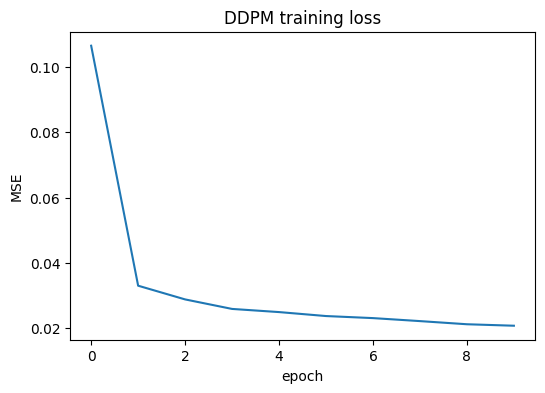

In [47]:

plt.figure(figsize=(6,4)); plt.plot(hist); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("DDPM training loss"); plt.show()


## 5) Sampling

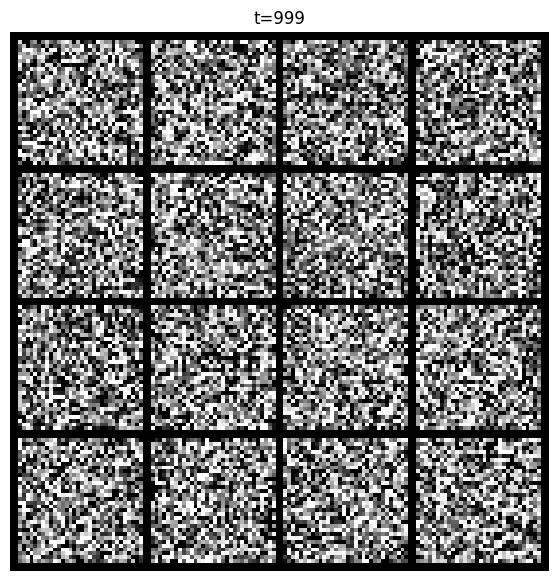

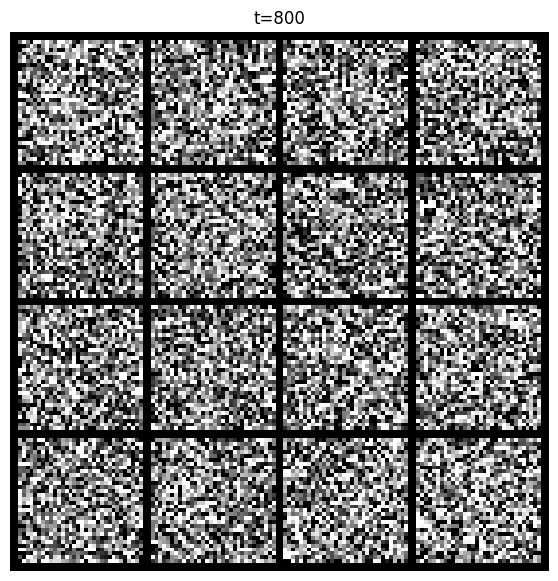

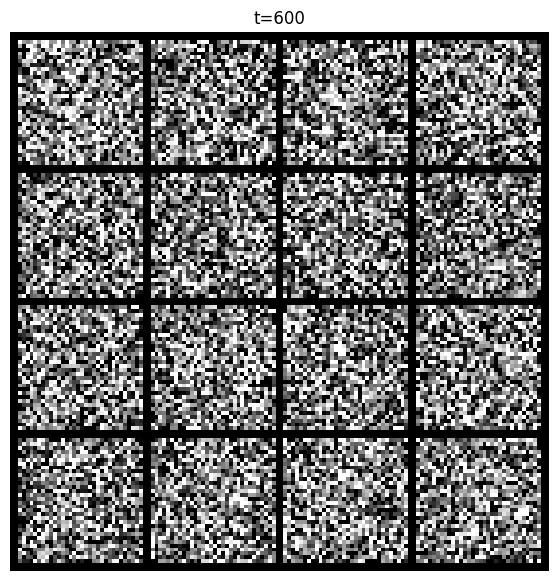

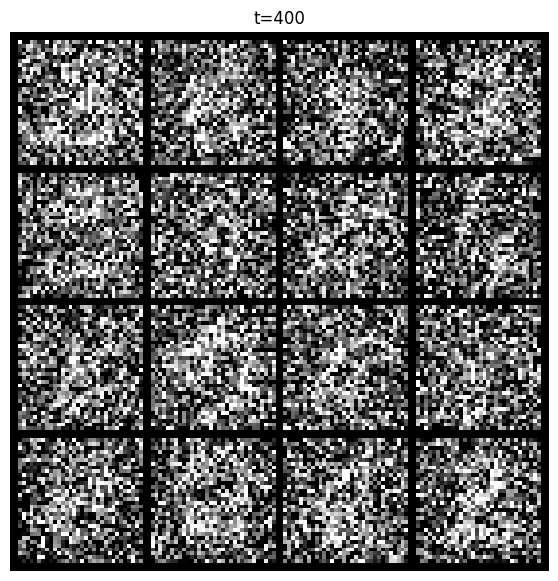

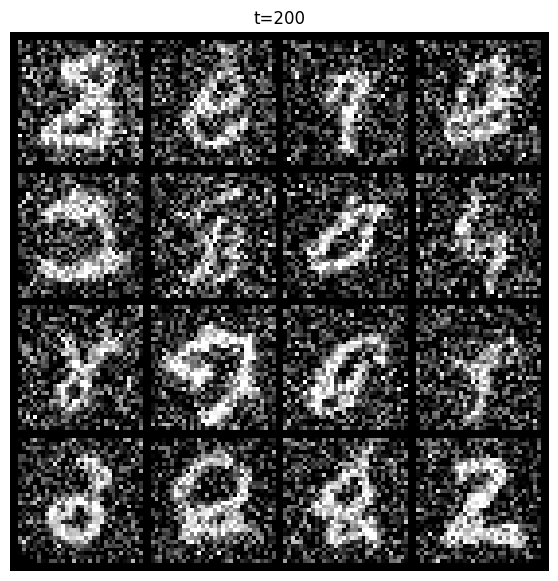

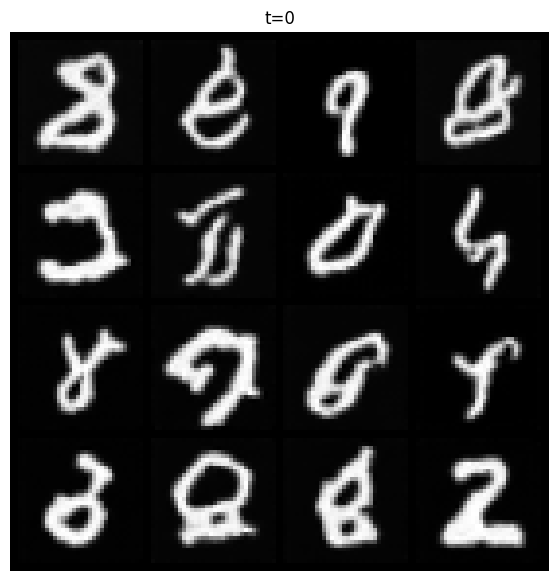

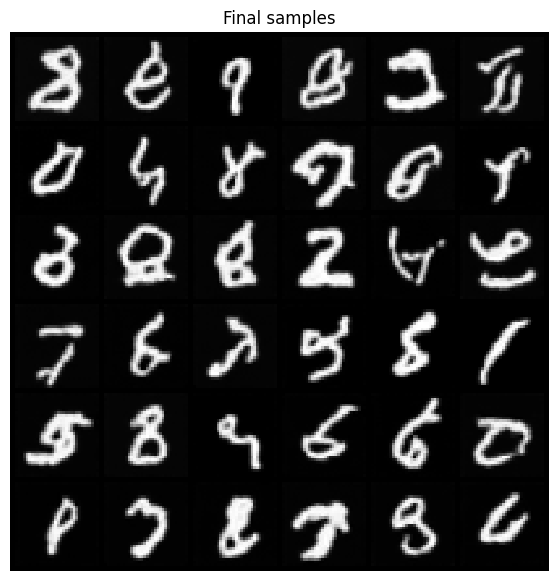

In [48]:

@torch.no_grad()
def sample_ddpm(unet, scheduler, n=36, device=DEVICE):
    unet.eval()
    x=torch.randn(n,1,IMG_SIZE,IMG_SIZE, device=device)
    for t in reversed(range(scheduler.T)):
        tt=torch.full((n,), t, device=device, dtype=torch.long)
        eps=unet(x, tt)
        x = scheduler.step(x, tt, eps)
        if t%200==0 or t==scheduler.T-1: 
            show_images(x[:16].clamp(-1,1).cpu(), nrow=4, title=f"t={t}")
    return x.clamp(-1,1)

samples=sample_ddpm(unet, sched, n=36, device=DEVICE)
show_images(samples.cpu(), nrow=6, title="Final samples")


## 6) Save & Load

In [51]:

os.makedirs("checkpoints", exist_ok=True)
torch.save(unet.state_dict(), "checkpoints/ddpm_unet.pt"); print("Saved to checkpoints/ddpm_unet.pt")
unet2=TinyUNet(1,64,128).to(DEVICE)
unet2.load_state_dict(torch.load("checkpoints/ddpm_unet.pt", map_location=DEVICE))
unet2.eval()
print("Reloaded OK")


Saved to checkpoints/ddpm_unet.pt
Reloaded OK


## 7) Next Steps


- Try `schedule="cosine"` and/or `timesteps=250` for faster sampling.  
- Add **EMA** of weights and use EMA model for sampling.  
- Switch to **RGB CIFAR-10** and increase UNet width/depth.  
- Try **v-prediction** and **DDIM** deterministic sampling.
